In [63]:
import cirq
from cirq.contrib.svg import SVGCircuit
import numpy as np
from qualtran.bloqs.hubbard_model import (
    SelectHubbard,
    PrepareHubbard,
    get_walk_operator_for_hubbard_model,
)
from qualtran import drawing

x_dim, y_dim, t = 2, 2, 5
mu = 4 * t

select = SelectHubbard(x_dim=x_dim, y_dim=y_dim, control_val=1)
prepare = PrepareHubbard(x_dim=x_dim, y_dim=y_dim, t=t, mu=mu)

In [2]:
drawing.show_bloqs([select, select.decompose_bloq()])
drawing.show_bloqs([prepare, prepare.decompose_bloq()])

In [3]:
print(select.signature)
print(prepare.signature)

Signature((Register(name='control', dtype=QBit(), shape=(), side=<Side.THRU: 3>), Register(name='U', dtype=BoundedQUInt(bitsize=1, iteration_length=2), shape=(), side=<Side.THRU: 3>), Register(name='V', dtype=BoundedQUInt(bitsize=1, iteration_length=2), shape=(), side=<Side.THRU: 3>), Register(name='p_x', dtype=BoundedQUInt(bitsize=1, iteration_length=2), shape=(), side=<Side.THRU: 3>), Register(name='p_y', dtype=BoundedQUInt(bitsize=1, iteration_length=2), shape=(), side=<Side.THRU: 3>), Register(name='alpha', dtype=BoundedQUInt(bitsize=1, iteration_length=2), shape=(), side=<Side.THRU: 3>), Register(name='q_x', dtype=BoundedQUInt(bitsize=1, iteration_length=2), shape=(), side=<Side.THRU: 3>), Register(name='q_y', dtype=BoundedQUInt(bitsize=1, iteration_length=2), shape=(), side=<Side.THRU: 3>), Register(name='beta', dtype=BoundedQUInt(bitsize=1, iteration_length=2), shape=(), side=<Side.THRU: 3>), Register(name='target', dtype=QAny(bitsize=8), shape=(), side=<Side.THRU: 3>)))
Signatu

## cirq.circuit for SELECT

In [4]:
from qualtran._infra.gate_with_registers import get_named_qubits

select_regs = get_named_qubits(select.signature.lefts())
print(*[{k: v} for k, v in select_regs.items()], sep="\n")

{'control': array([cirq.NamedQubit('control')], dtype=object)}
{'U': array([cirq.NamedQubit('U')], dtype=object)}
{'V': array([cirq.NamedQubit('V')], dtype=object)}
{'p_x': array([cirq.NamedQubit('p_x')], dtype=object)}
{'p_y': array([cirq.NamedQubit('p_y')], dtype=object)}
{'alpha': array([cirq.NamedQubit('alpha')], dtype=object)}
{'q_x': array([cirq.NamedQubit('q_x')], dtype=object)}
{'q_y': array([cirq.NamedQubit('q_y')], dtype=object)}
{'beta': array([cirq.NamedQubit('beta')], dtype=object)}
{'target': array([cirq.NamedQubit('target0'), cirq.NamedQubit('target1'),
       cirq.NamedQubit('target2'), cirq.NamedQubit('target3'),
       cirq.NamedQubit('target4'), cirq.NamedQubit('target5'),
       cirq.NamedQubit('target6'), cirq.NamedQubit('target7')],
      dtype=object)}


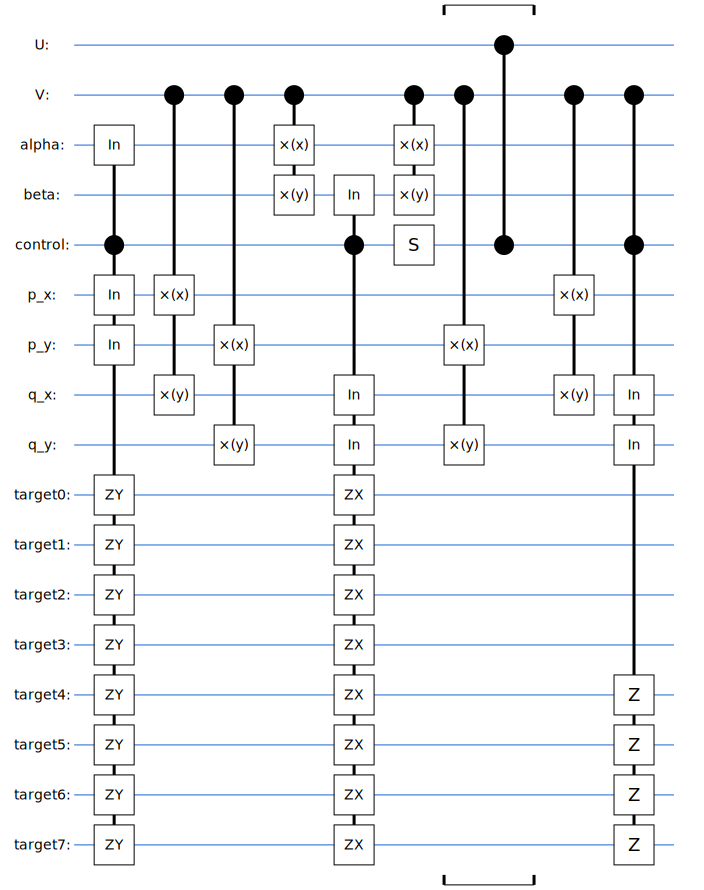

In [5]:
select_circuit, _ = select.decompose_bloq().to_cirq_circuit(**select_regs)
SVGCircuit(select_circuit)

In [6]:
from qualtran.bloqs.hubbard_model import SelectedMajoranaFermion, ApplyGateToLthQubit


def check(binst):
    if isinstance(binst.bloq, (SelectedMajoranaFermion, ApplyGateToLthQubit)):
        return True
    return binst.bloq.supports_decompose_bloq()


flattened_select = select.decompose_bloq().flatten(check)
drawing.show_bloqs([flattened_select])

In [7]:
from cirq.contrib.svg import SVGCircuit

flattened_select_circuit, _ = flattened_select.to_cirq_circuit(**select_regs)
print("tot qubits ", len(flattened_select_circuit.all_qubits()))
print("tot ops ", len(list(flattened_select_circuit.all_operations())))

tot qubits  37
tot ops  119


## Improve the ancilla allocation

In [8]:
qubit_manager = cirq.ops.GreedyQubitManager("_c")

greedy_select_circuit, _ = flattened_select.to_cirq_circuit(
    qubit_manager=qubit_manager, **select_regs
)
print(greedy_select_circuit)

                                                  ┌──┐           ┌─────┐                     ┌──┐           ┌─────┐                                  ┌──┐           ┌─────┐                     ┌──┐           ┌─────┐          ┌─────┐   ┌──┐                                 ┌──┐           ┌─────┐                     ┌──┐           ┌─────┐                                  ┌──┐           ┌─────┐                     ┌──┐           ┌─────┐                     ┌──┐
U: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────────────────────────────────────────────────────────────

In [9]:
print("tot qubits ", len(greedy_select_circuit.all_qubits()))
print("tot ops ", len(list(greedy_select_circuit.all_operations())))

tot qubits  22
tot ops  119


## PREPARE

In [22]:
drawing.show_bloqs([prepare, prepare.decompose_bloq()])

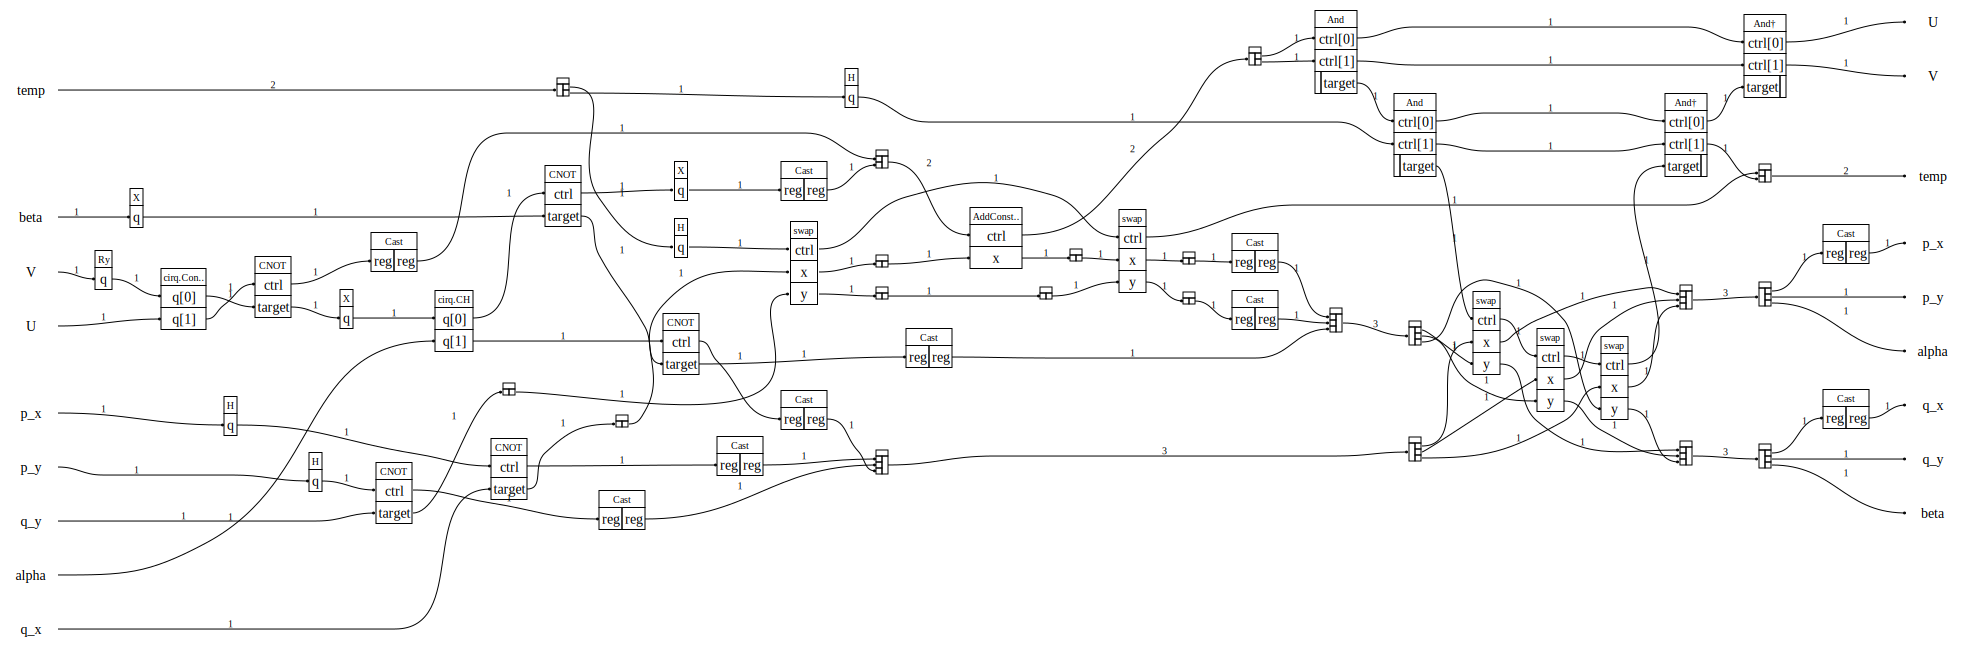

In [60]:
from qualtran.bloqs.hubbard_model import AddConstantMod, PrepareUniformSuperposition, MultiAnd
from qualtran._infra.adjoint import Adjoint


def check(binst):
    if isinstance(binst.bloq, (PrepareUniformSuperposition, MultiAnd, Adjoint)):
        return True
    return binst.bloq.supports_decompose_bloq()
    # fix because SelectedMajoranaFermion.supports_decompose_bloq() wrongly evaluates to False


flattened_prepare = prepare.decompose_bloq().flatten(check)

drawing.show_bloq(flattened_prepare)

In [59]:
print(
    *np.unique([str(type(binst.bloq)) for binst, _, _ in flattened_prepare.iter_bloqnections()]),
    sep="\n",
)

<class 'qualtran._infra.adjoint.Adjoint'>
<class 'qualtran.bloqs.arithmetic.addition.AddConstantMod'>
<class 'qualtran.bloqs.basic_gates.cnot.CNOT'>
<class 'qualtran.bloqs.basic_gates.hadamard.Hadamard'>
<class 'qualtran.bloqs.basic_gates.rotation.Ry'>
<class 'qualtran.bloqs.basic_gates.swap.TwoBitCSwap'>
<class 'qualtran.bloqs.basic_gates.x_basis.XGate'>
<class 'qualtran.bloqs.mcmt.and_bloq.And'>
<class 'qualtran.bloqs.util_bloqs.Cast'>
<class 'qualtran.bloqs.util_bloqs.Join'>
<class 'qualtran.bloqs.util_bloqs.Split'>
<class 'qualtran.cirq_interop._cirq_to_bloq.CirqGateAsBloq'>


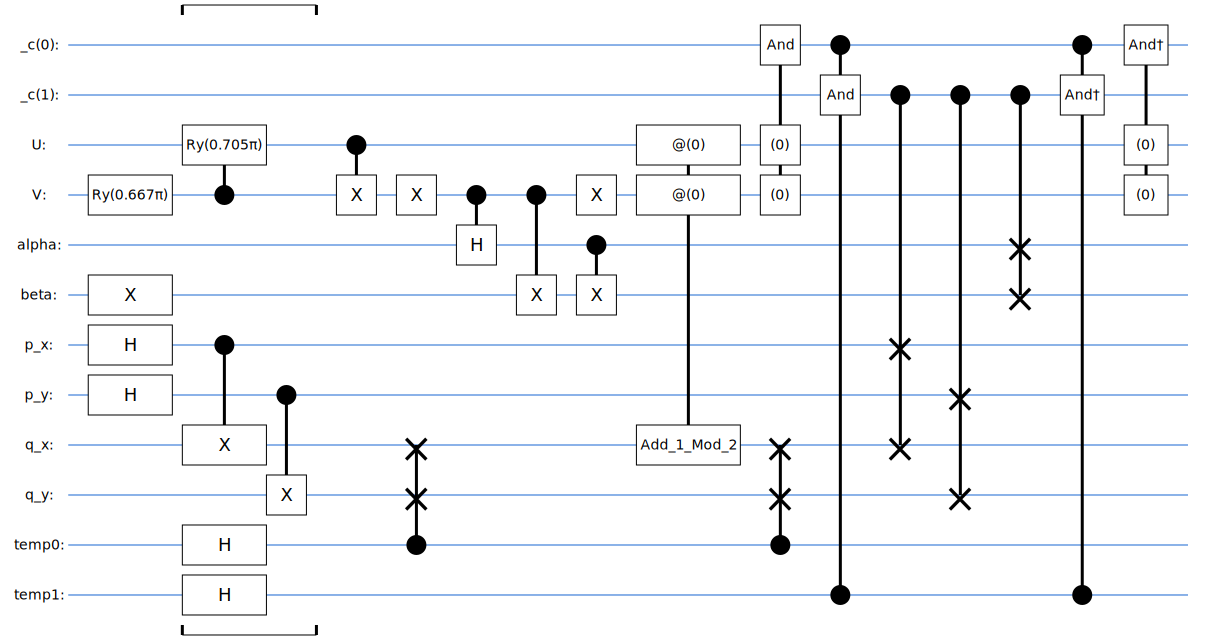

In [61]:
qubit_manager = cirq.ops.GreedyQubitManager("_c")
prepare_regs = get_named_qubits(prepare.signature.lefts())
greedy_prepare_circuit, _ = flattened_prepare.to_cirq_circuit(**prepare_regs)
SVGCircuit(greedy_prepare_circuit)

TODO: fix the classical addition gate

## Full walk operator

In [112]:
x_dim, y_dim, t = 3, 3, 5
mu = 4 * t

walk = get_walk_operator_for_hubbard_model(x_dim=x_dim, y_dim=y_dim, t=t, mu=mu)
drawing.show_bloqs([walk, walk.decompose_bloq()])

In [113]:
from qualtran.bloqs.hubbard_model import *
from qualtran._infra.adjoint import Adjoint
from qualtran.bloqs.qubitization_walk_operator import ReflectionUsingPrepare

decomposed_types = (
    ReflectionUsingPrepare,
    SelectHubbard,
    PrepareHubbard,
    SelectedMajoranaFermion,
    ApplyGateToLthQubit,
    PrepareUniformSuperposition,
    MultiAnd,
)


def check(binst):
    if isinstance(binst.bloq, decomposed_types):
        return True
    if isinstance(binst.bloq, Adjoint) and isinstance(binst.bloq.subbloq, decomposed_types):
        return True
    return binst.bloq.supports_decompose_bloq()


flattened_walk = walk.decompose_bloq().flatten(check)

drawing.show_bloqs([flattened_walk])

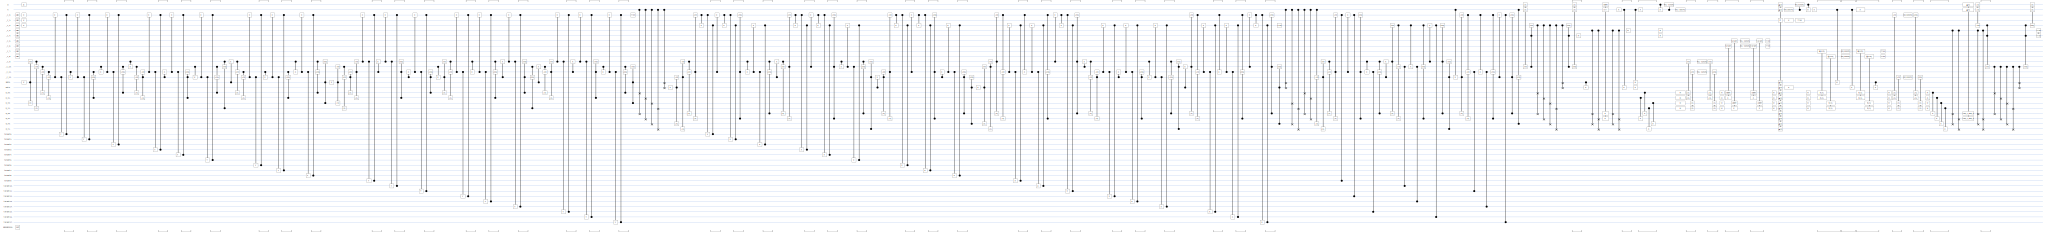

In [114]:
qubit_manager = cirq.ops.GreedyQubitManager("_c")
walk_regs = get_named_qubits(walk.signature.lefts())

walk_circuit, _ = flattened_walk.to_cirq_circuit(
    qubit_manager=qubit_manager, **walk_regs
)
SVGCircuit(walk_circuit)

In [115]:
print("tot qubits ", len(walk_circuit.all_qubits()))
print("tot ops ", len(list(walk_circuit.all_operations())))

tot qubits  43
tot ops  381
